Generate a plot of winning bid arrival times for the earliest bid detection by any relay.

Author: Tripoli - Data Always \
Date Modified: December 11, 2023 \
License: CC0

<!-- public keys from Titan: https://docs.titanbuilder.xyz/builder-public-keys -->

0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed047da1cefb82d16e1a13e6b50de31a86f5b233d1e6bbaca3c69173

0xabf1ad5ec0512cb1adabe457882fa550b4935f1f7df9658e46af882049ec16da698c323af8c98c3f1f9570ebc4042a83

0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2cf01c9a361f465597a5dc3a5472bd98843bac88d2541a78eab08

0xb26f96664274e15fb6fcda862302e47de7e0e2a6687f8349327a9846043e42596ec44af676126e2cacbdd181f548e681

0x95c8cc31f8d4e54eddb0603b8f12d59d466f656f374bde2073e321bdd16082d420e3eef4d62467a7ea6b83818381f742

0x8509ecb595da0eda2c6fced4e287f0510a2c2dba5f80ee930503ef86e268d808a6df25e397177da06cd479771ce66840

0xa32aadb23e45595fe4981114a8230128443fd5407d557dc0c158ab93bc2b88939b5a87a84b6863b0d04a4b5a2447f847

0xae2ffc6986c9a368c5ad2d51f86db2031d780f6ac9b2348044dea4e3a75808b566c935099de8b1a1609db322f2110e7a

0xb4a435cf816291596fe2e405651ec8b6c80b9cc34dace3c83202ca489a833756c9a0672ebdc17f23d9d43163db1caa5d

0xb47963246adef02cd3e61cbb648c04fd99b05e28a616aef3aa7fb688c17b10d1ce9662b61a600efbdd110e93d62d5144

0xaf10542267816e91adbc8f4a6754765d492534f8325f34a2e89caa2ba45c7158f6deaa6e7fb454ebb6f6a1495fe63dba

0x94829e6f7a598a2f2dfdd9e1246d7cfdc30a626666d9419f3c147cc954507e97184c598dc109f4d05c2139c48af6746c

In [4]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import pandas as pd # type: ignore

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Titan Builder public key HTML
url = 'https://docs.titanbuilder.xyz/builder-public-keys'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

assorted_list = [tag.text for tag in soup.find_all('li')]
titan_pub_key_list = [key for key in assorted_list if key.startswith('0x')]



In [12]:
# Read 921 blocks' bidding data. Titan won these 921 blocks.
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format
# Read the titan 921 block bidding history parquet file
dft = pd.read_parquet('titan921.parquet', engine='pyarrow')


In [13]:
# Load winning bid block history data
#  !!!the data here is NOT THE LATEST FROM THE OG MEV DATA ALWAYS PROJECT. Go to: https://github.com/dataalways/mevboost-data to sync.
base_path = '../data/'
file_paths = os.listdir(base_path)

dfs = []
for file in file_paths:
    if len(file) < 10: #.DS_store
        continue
    
    df_tmp = pd.read_parquet(os.path.join(base_path, file))
    dfs.append(df_tmp)

df = pd.concat(dfs)
df = df[df['payload_delivered'] == True]
df.sort_values(by=['block_number', 'bid_timestamp_ms'], ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)

In [14]:
df.dropna(subset='relay', inplace=True)
# drop non-boost blocks

df.drop_duplicates(subset='block_hash', keep='first', inplace=True)
# drop relays that got the data late, only keep the earliest.

print("Before merge bidding numbers")
print(df.shape[0])
# 1148978 blocks winning bid data

df.reset_index(inplace=True, drop=True)

Before merge bidding numbers
1185161


In [20]:
## This section is used to prep builder related dataset for future grouping.
# prepare builder label data frame from the winning block data, these are the builders succeed in submitting bidding and building block or blocks.
# We only need the latest builder label matching the pubkey
# 首先对 'builder_pubkey' 和 'block_timestamp' 进行排序
df = df.sort_values(by=['builder_pubkey', 'block_timestamp'])

# 然后，选择每一个 'builder_pubkey' 的最后一个 'builder_label'，并把这两列放入一个新的 DataFrame
df_builder_info = df.groupby('builder_pubkey')[['builder_label']].last().reset_index()


# df_builder_info = pd.DataFrame(df[['builder_label', 'builder_pubkey']].drop_duplicates())

print(df_builder_info.shape[0])
# print()

# extract builder pubkeys from the 921 titan bidding data. Some of these builders NEVER built a block. 
# We will use FAILED_UNKNOWN_BUILDERS as their label
dft_builder = dft[['builder_pubkey']].drop_duplicates()

# Find out the FAILED_UNKNOWN_BUILDERS, create a data frame for them and add the data frame to the overall builder data frame.
not_in_df_builder_info = dft_builder[~dft_builder['builder_pubkey'].isin(df_builder_info['builder_pubkey'])]
missing_labels = pd.DataFrame({'builder_pubkey': not_in_df_builder_info['builder_pubkey'].unique(), 
                               'builder_label': 'FAILED_UNKNOWN_BUILDERS'})
df_builder_info = pd.concat([df_builder_info, missing_labels], ignore_index=True)


unique_labels = df_builder_info['builder_label'].unique()
# prep titan builder data frame
titan_builder_labels = df_builder_info[df_builder_info['builder_label'].str.contains('titan', case=False)]

# prep EigenPhi builder data frame
eigenphi_builder_labels = df_builder_info[df_builder_info['builder_label'].str.contains('eigenphi', case=False)]

# prep rsync builder data frame
rsync_builder_labels = df_builder_info[df_builder_info['builder_label'].str.contains('rsync', case=False)]

# prep beaver builder data frame
beaver_builder_labels = df_builder_info[df_builder_info['builder_label'].str.contains('beaver', case=False)]

# # The code below can be used to check Titan's pubkeys: current vs.
# current_titan_pub_key_set = set(titan_pub_key_list)
# total_titan_labels_set = set(titan_labels['builder_pubkey'])

# only_in_titan_labels = total_titan_labels_set.difference(current_titan_pub_key_set)
# print(f"builder_pubkey's in total titan_labels but not in current titan_pub_key_list:\n {only_in_titan_labels}")
# # 计算差集
# only_in_titan_pub_key_list = current_titan_pub_key_set.difference(total_titan_labels_set)

# # 输出结果
# print(f"builder_pubkey's in current titan_pub_key_list but not in total titan_labels:\n {only_in_titan_pub_key_list}")


386


In [23]:
# analyze the bidding of block 19440930
dftb_0930 = dft[dft['block_number'] == 19440930]

# get the winning bid block info for reference
df_0930 = df[df['block_number'] == 19440930]

# now let's calculate the time difference
# take out the block final timestamp
# get the time difference between block final timestamp and bid timestamp

# Remove the ' UTC' from timestamp strings and convert to datetime
dftb_0930.loc[:, 'block_timestamp'] = pd.to_datetime(dftb_0930['block_timestamp'].str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S', errors='coerce')
dftb_0930.loc[:, 'timestamp'] = pd.to_datetime(dftb_0930['timestamp'].str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# 计算时间差并且存储在新的 Dataframe 中 Calculate the time difference and store it in a new Dataframe.
ts_diff_df = (dftb_0930['block_timestamp'] - dftb_0930['timestamp']).apply(lambda x: x.total_seconds()) * 1000

# 添加新的列到原始的 Dataframe 中.  Add a new column, ts_diff, as ms difference, to the original Dataframe.
# if ts_diff > 0, bid before 12s, if ts_diff<0, bid after 12s
dftb_0930 = pd.concat([dftb_0930, ts_diff_df.rename('ts_diff')], axis=1)

print(dftb_0930.shape[0])



2750


min:-3.0; max:8.0
Merged rows:2750


/var/folders/jp/k1yzl0wx5jx7ff0qjcq3v7m00000gn/T/ipykernel_60967/1534108980.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merged_df.groupby(['builder_label', 'ts_diff_bins']).size().unstack(fill_value=0)


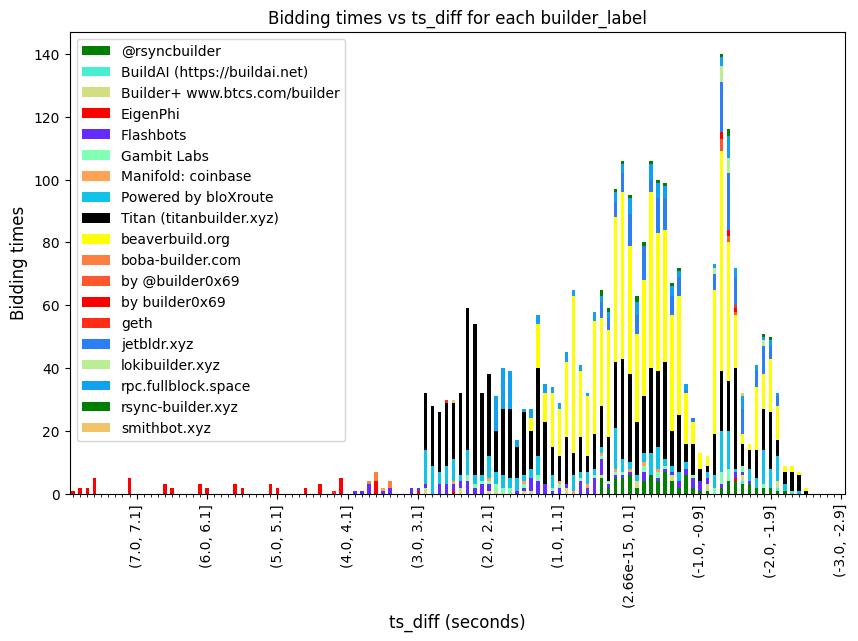

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.ticker as ticker

# 将 `ts_diff` 从毫秒转换为秒
dftb_0930['ts_diff_secs'] = dftb_0930['ts_diff'] / 1000

# 计算 ts_diff 的最小和最大值
x_min = np.floor(dftb_0930['ts_diff_secs'].min())
x_max = np.ceil(dftb_0930['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))

# 创建 `ts_diff_secs` 的区间（每0.1秒）
dftb_0930['ts_diff_bins'] = pd.cut(
    dftb_0930['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

df_builder_info = df_builder_info.drop_duplicates(subset=['builder_pubkey', 'builder_label'])

merged_df = pd.merge(dftb_0930, df_builder_info, on='builder_pubkey', how='inner')
print("Merged rows:" + str(merged_df.shape[0]))

grouped = merged_df.groupby(['builder_label', 'ts_diff_bins']).size().unstack(fill_value=0)


highlight_labels = [label.lower() for label in ["EigenPhi", "rsync", "titan", "Beaver"]]

# 创建颜色映射
labels = merged_df['builder_label'].unique()

normal_colors = cm.rainbow(np.linspace(0, 1, len(labels)))
highlight_colors = ["red", "green", "black", "yellow"] 

color_map = {}
labels_list = list(labels)  # 将numpy数组转换为列表

for label in labels:
    # 如果该标签包含 highlight_labels 中的任何一个，则将其视为高亮标签
    if any(hl in label.lower() for hl in highlight_labels):
        color_map[label] = highlight_colors[highlight_labels.index(next(hl for hl in highlight_labels if hl in label.lower()))]
    else:
        color_map[label] = normal_colors[labels_list.index(label)]  # 使用列表的index方法


# 在生成图之前，先获取并排序图例标签
handles, labels = ax.get_legend_handles_labels()  
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

ax = grouped.T.plot(kind='bar', stacked=True, color=[color_map[i] for i in labels], figsize=(10,6))

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 设置主要刻度为1秒
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1))   # 设置次要刻度为0.1秒

# 逆转x轴
ax.invert_xaxis()

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bidding times', fontsize=12)
plt.title('Bidding times vs ts_diff for each builder_label')

# 使用排序后的标签和句柄来创建图例
ax.legend(handles, labels)  

plt.show()


# ax = grouped.T.plot(kind='bar', stacked=True, color=[color_map[i] for i in merged_df['builder_label'].unique()], figsize=(10,6))

# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 设置主要刻度为1秒
# ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1))   # 设置次要刻度为0.1秒

# # 逆转x轴
# ax.invert_xaxis()


# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bidding times', fontsize=12)
# plt.title('Bidding times vs ts_diff for each builder_label')
# plt.show()


In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.ticker as ticker

# 将 `ts_diff` 从毫秒转换为秒
dftb_0930['ts_diff_secs'] = dftb_0930['ts_diff'] / 1000

# 计算 ts_diff 的最小和最大值
x_min = np.floor(dftb_0930['ts_diff_secs'].min())
x_max = np.ceil(dftb_0930['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))

# 创建 `ts_diff_secs` 的区间（每0.1秒）
dftb_0930['ts_diff_bins'] = pd.cut(
    dftb_0930['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

df_builder_info = df_builder_info.drop_duplicates(subset=['builder_pubkey', 'builder_label'])

merged_df = pd.merge(dftb_0930, df_builder_info, on='builder_pubkey', how='inner')
print("Merged rows:" + str(merged_df.shape[0]))

grouped = merged_df.groupby(['builder_label', 'ts_diff_bins']).size().unstack(fill_value=0)

highlight_labels = [label.lower() for label in ["EigenPhi", "rsync", "Titan", "Beaver"]]

# 只保留包含 highlight_labels 的行
filtered_df = dftb_0930[dftb_0930['builder_label'].apply(lambda x: any(hl in x.lower() for hl in highlight_labels))]

merged_df = pd.merge(filtered_df, df_builder_info, on='builder_pubkey', how='inner')

normal_colors = cm.rainbow(np.linspace(0, 1, len(merged_df['builder_label'].unique())))
highlight_colors = ["red", "green", "blue", "yellow"]

color_map = {}
labels_list = list(merged_df['builder_label'].unique())  # 更新 labels_list

for label in labels_list:
    if any(hl in label.lower() for hl in highlight_labels):
        color_map[label] = highlight_colors[highlight_labels.index(next(hl for hl in highlight_labels if hl in label.lower()))]
    else:
        color_map[label] = normal_colors[labels_list.index(label)]  # 使用列表的index方法

grouped = merged_df.groupby(['builder_label', 'ts_diff_bins']).size().unstack(fill_value=0)

ax = grouped.T.plot(kind='bar', stacked=True, color=[color_map[i] for i in grouped.columns], figsize=(10,6))

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 设置主要刻度为1 ```python
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1))   # 设置次要刻度为0.1秒
ax.invert_xaxis()

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bidding times', fontsize=12)
plt.title('Bidding times vs ts_diff for each builder_label')
plt.show()


min:-3.0; max:8.0
Merged rows:2750


/var/folders/jp/k1yzl0wx5jx7ff0qjcq3v7m00000gn/T/ipykernel_60967/1003959564.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = merged_df.groupby(['builder_label', 'ts_diff_bins']).size().unstack(fill_value=0)


KeyError: 'builder_label'

In [114]:


# 执行merge操作，并将结果保留在一个新的DataFrame中，而不是直接覆盖dft_block_bidding
merged = pd.merge(dft_block_bidding, df_builder_info, on='builder_pubkey', suffixes=('', '_y'))
print(merged.shape[0])

# 查找哪些行在合并后丢失了
missing_rows = dft_block_bidding.loc[dft_block_bidding.index.difference(merged.index)]

print(missing_rows)

# # 将dft_block_bidding与df_builder_info合并
# dft_block_bidding = pd.merge(dft_block_bidding, df_builder_info, on='builder_pubkey', suffixes=('', '_y'))
# print(dft_block_bidding.shape[0])

4459
                 block_timestamp               relay     slot  \
246901   2024-03-15 14:25:47 UTC           flashbots  8640727   
246902   2024-03-15 14:25:47 UTC          ultrasound  8640727   
246903   2024-03-15 14:25:47 UTC  bloxrouteRegulated  8640727   
246904   2024-03-15 14:25:47 UTC           flashbots  8640727   
246905   2024-03-15 14:25:47 UTC  bloxrouteMaxProfit  8640727   
...                          ...                 ...      ...   
1680094  2024-03-15 14:25:47 UTC  bloxrouteMaxProfit  8640727   
1680095  2024-03-15 14:25:47 UTC           flashbots  8640727   
1680096  2024-03-15 14:25:47 UTC          ultrasound  8640727   
1680097  2024-03-15 14:25:47 UTC            agnostic  8640727   
1680098  2024-03-15 14:25:47 UTC          ultrasound  8640727   

                                               parent_hash  \
246901   0x4225a8686dab0a87b7e84109b56e2ee1dea79dd404be...   
246902   0x4225a8686dab0a87b7e84109b56e2ee1dea79dd404be...   
246903   0x4225a8686dab0a87b

In [ ]:
# 将dft_block_bidding与df_builder_info合并
dft_block_bidding = pd.merge(dft_block_bidding, df_builder_info, on='builder_pubkey')

# Now let's build the chart
dft_block_bidding['timestamp_difference'] = dft_block_bidding['timestamp_s'] - dft_block_bidding['timestamp_ms']/1000.0
min_time = np.floor(dft_block_bidding['timestamp_difference'].min()) 
max_time = np.ceil(dft_block_bidding['timestamp_difference'].max()) 

# 按照builder_label进行分组
dft_grouped = (dft_block_bidding.groupby(['builder_label', pd.cut(dft_block_bidding["timestamp_difference"], np.arange(min_time, max_time, 0.1))])
                                ['value'].sum().unstack(level=0).fillna(0))

print('builder_label' in dft_block_bidding.columns)

# 用0填充一个新的数据帧，这个数据帧的列与dft_grouped相同.
zero_bids = pd.DataFrame(0, index=['builder_label_with_zero_bids'], columns=dft_grouped.columns)
dft_grouped = dft_grouped.append(zero_bids)
dft_grouped.rename({0: 'builder_label_with_zero_bids'}, inplace=True)


# # 创建图表
# ax = dft_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
# ax.set_xlabel("Timestamp difference (s)")
# ax.set_ylabel("Value")
# plt.show()

ax = dft_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.bar(np.arange(len(dft_grouped)), np.zeros(len(dft_grouped)), color='none', edgecolor='gray', label='builder_label_with_zero_bids')
ax.set_xlabel("Timestamp difference (s)")
ax.set_ylabel("Value")
ax.legend()
plt.show()

In [11]:

min_block_number = df['block_number'].min()
max_block_number = df['block_number'].max()

# print("Minimum block number:", min_block_number)
# print("Maximum block number:", max_block_number)

# df_selected = df[df['block_number'] == 19440930]
# print(df_selected)


df = df[df['block_number'] == 19440930]
print(df)
print(df.shape[0])


df_titan_blocks = df[df['builder_pubkey'].isin(titan_pub_key_list)]
df_titan_block0930 = df_titan_blocks[df_titan_blocks['block_number'] == "19440938"]
# print(df_titan_block0930)

df_filtered = df_1kselected[df_1kselected['block_number'].isin(df_titan_block0930['block_number'])]
print(df_1kselected['block_number'].unique())
print(df_titan_block0930['block_number'].unique())


print(df_filtered)


             block_datetime     slot  block_number  \
1025786 2024-03-15 14:25:47  8640727      19440930   

                                                block_hash              value  \
1025786  0xd24d07a0939a6e7945554385dd21611c403938fa3700...  28545556981639481   

         base_fee_per_gas   gas_limit    gas_used  num_tx  builder_label  ...  \
1025786      4.623672e+10  30000000.0  11235200.0   153.0  Titan Builder  ...   

              relay bid_timestamp_ms  slot_time_ms  \
1025786  ultrasound     1.710513e+12       12331.0   

                                           proposer_pubkey  \
1025786  0xb899e5ba806b9e559849fff94d58f8dc859b9295c72d...   

                             proposer_mev_recipient optimistic_submission  \
1025786  0x388c818ca8b9251b393131c08a736a67ccb19297                 False   

                              builder_fee_recipient block_timestamp  \
1025786  0x388c818ca8b9251b393131c08a736a67ccb19297    1.710513e+09   

                                 

In [12]:
# Commented code for testing Titan builder and its pubkeys
# df_titan_unique = df[df['builder_label'].str.contains("Titan", na=False)]
# df_titan_unique = df_titan_unique.drop_duplicates(subset=['builder_pubkey'])
# df_titan_unique_filtered = df_titan_unique[df_titan_unique['builder_pubkey'].isin(filtered_pub_key_list)]
# print(df_titan_unique_filtered[['builder_label', 'builder_pubkey']])
# num_rows = df_titan_unique_filtered.shape[0]
# print(num_rows)

df_titan_blocks = df[df['builder_pubkey'].isin(titan_pub_key_list)]
df_titan_filtered_blocks = df_titan_blocks[df_titan_blocks['block_number'] < 19440938]
df_titan_first_1000_blocks = df_titan_filtered_blocks.sort_values(by='block_number', ascending=False).head(1000)
# df_titan_first_1000_blocks.to_csv('titan_first_1000_blocks.csv', index=False)

# print(df_titan_first_1000_blocks.head(10))


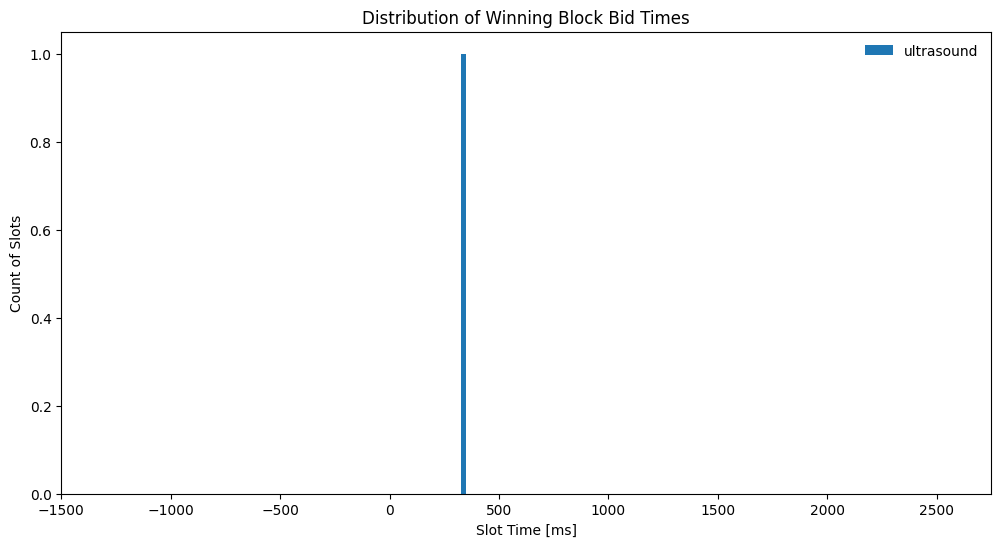

In [13]:
relays = list(df['relay'].value_counts().head(5).index)

fig = plt.figure(figsize = (12, 6))
plt.title('Distribution of Winning Block Bid Times')

bin_size = 25
bins = np.arange(-12000, 12000, bin_size)

df_counts = pd.DataFrame()
for xx in range(len(relays)):
    df_counts = pd.concat([df_counts, df[df['relay'] == relays[xx]]])
    plt.hist([x-12000 for x in df_counts['slot_time_ms']], bins=bins, label = relays[xx], zorder = 1 - xx/100)

plt.xlim([-1500, 2750])
plt.xlabel('Slot Time [ms]')
plt.ylabel('Count of Slots')
plt.ylim([0, None])

plt.legend(loc = 'upper right', frameon=False)
plt.show()